In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr
import sys
sys.path.append('/home/563/rl5183/Functions')
import model_functions as func
from importlib import reload
import scipy
from scipy import signal
import cartopy.crs as ccrs
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
func=reload(func)

In [3]:
#Import ersst SST data and detrend
ersst_ds = xr.open_dataset('/g/data/ob22/jxb548/OBSDATA/ersstv5.1854_2019.regrid240x120.nc')
ersst_data = ersst_ds.sst.sel(time=slice('1950-01', '2014-12'))
ersst_dt = np.apply_along_axis(func.detrend_2step, 0, ersst_data)
ersst = xr.DataArray(ersst_dt, coords=ersst_data.coords, attrs=ersst_data.attrs)

In [4]:
#Import AWAP precip
precip_ds = xr.open_dataset('/home/563/rl5183/Datasets/rr_monthly.1900-2015.regrid240x120.nc')
pr_aus = precip_ds.rr.sel(lon = slice(112, 156)).sel(lat=slice(-44, -10)).sel(time=slice('1950-01', '2014-12'))
pr_ea = precip_ds.rr.sel(lon = slice(140, 156)).sel(lat=slice(-44, -10)).sel(time=slice('1950-01', '2014-12'))
pr_timeseries = pr_ea.mean(dim=['lat', 'lon'])

In [5]:
#landmask
landmask_ds = xr.open_dataset('/g/data/eg3/pfd548/gridarea/land-sea_mask/fractional_land.1.5-deg.nc')
landmask = landmask_ds.mean(dim='time')

In [8]:
from scipy.stats.stats import pearsonr
nino34 = func.nino34(ersst)
nino3 = func.nino3(ersst)
nino4 = func.nino4(ersst)
pr_anom = pr_timeseries - pr_timeseries.mean(dim='time')
nino34_r, nino34_p = pearsonr(pr_anom, nino34)
nino3_r, nino3_p = pearsonr(pr_anom, nino3)
nino4_r, nino4_p = pearsonr(pr_anom, nino4)

In [12]:
nino34_r

-0.15373656525955046

### Spatial Corr over globe

In [8]:
func=reload(func)

In [13]:
#DJF
pearson_djf_return = func.spatial_corr_over_sea(pr_timeseries, ersst, 'DJF')
pearson_djf = xr.DataArray(pearson_djf_return, dims=['lat', 'lon'])
pearson_djf.coords['lat'] = ersst.lat.values
pearson_djf.coords['lon'] = ersst.lon.values
pearson_djf = pearson_djf.where(landmask.data==0)
#SON
pearson_son_return = func.spatial_corr_over_sea(pr_timeseries, ersst, 'SON')
pearson_son = xr.DataArray(pearson_son_return, dims=['lat', 'lon'])
pearson_son.coords['lat'] = ersst.lat.values
pearson_son.coords['lon'] = ersst.lon.values
pearson_son = pearson_son.where(landmask.data==0)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


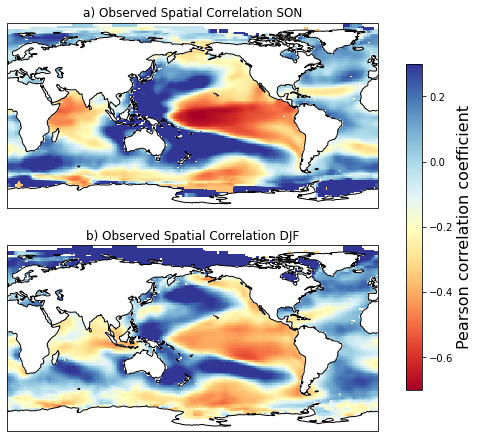

In [32]:
#Plots
fig = plt.figure(figsize=(10,7.5))
axs = []

vmin = -0.7
vmax = 0.3


ax = fig.add_subplot(211, projection=ccrs.PlateCarree(180))
C = pearson_son.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='RdYlBu')
ax.coastlines()
ax.set_title('a) Observed Spatial Correlation SON')
axs.append(ax)

ax = fig.add_subplot(212, projection=ccrs.PlateCarree(180))
C = pearson_djf.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='RdYlBu')
ax.coastlines()
ax.set_title('b) Observed Spatial Correlation DJF')
axs.append(ax)

cbar = plt.colorbar(C, ax=axs, shrink=0.8)
cbar.ax.set_ylabel('Pearson correlation coefficient', fontsize=16)

#plt.savefig('spatial_corr_over_sea.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')

### Spatial Corr over Equatorial Pacific

In [26]:
nino_region = ersst.sel(lat=slice(-5,5)).sel(lon=slice(160, 270))

In [27]:
#DJF
pearson_djf_return_eq = func.spatial_corr_over_sea(pr_timeseries, nino_region, 'DJF')
pearson_djf_eq = xr.DataArray(pearson_djf_return_eq, dims=['lat', 'lon'])
pearson_djf_eq.coords['lat'] = nino_region.lat.values
pearson_djf_eq.coords['lon'] = nino_region.lon.values
#SON
pearson_son_return_eq = func.spatial_corr_over_sea(pr_timeseries, nino_region, 'SON')
pearson_son_eq = xr.DataArray(pearson_son_return_eq, dims=['lat', 'lon'])
pearson_son_eq.coords['lat'] = nino_region.lat.values
pearson_son_eq.coords['lon'] = nino_region.lon.values

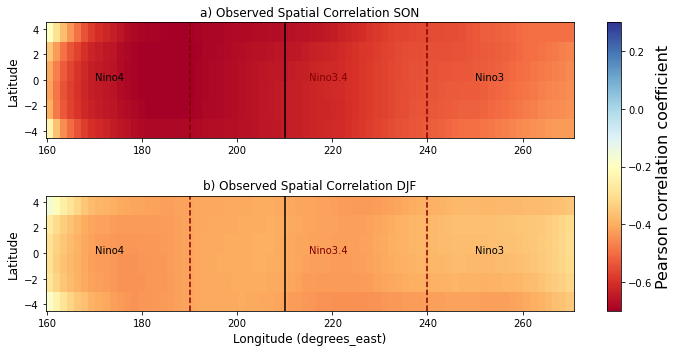

In [33]:
#Plot obs spatial corr and mmm spatial corr DJF and SON

fig = plt.figure(figsize=(10,5))
axs = []

vmin = -0.7
vmax = 0.3 


ax = fig.add_subplot(211)
C = pearson_son_eq.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, cmap='RdYlBu')
ax.set_title('a) Observed Spatial Correlation SON')
ax.set_xlabel(' ')
ax.set_ylabel('Latitude', fontsize=12)
axs.append(ax)
plt.axvline(210, 0, 1, color='black')
plt.axvline(190, 0, 1, color='maroon', linestyle='--')
plt.axvline(240, 0, 1, color='maroon', linestyle='--')
plt.annotate('Nino4', (170,0))
plt.annotate('Nino3', (250,0))
plt.annotate('Nino3.4', (215,0), color='maroon')

ax = fig.add_subplot(212)
C = pearson_djf_eq.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, cmap='RdYlBu')
ax.set_title('b) Observed Spatial Correlation DJF')
ax.set_xlabel('Longitude (degrees_east)', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
axs.append(ax)
plt.axvline(210, 0, 1, color='black')
plt.axvline(190, 0, 1, color='maroon', linestyle='--')
plt.axvline(240, 0, 1, color='maroon', linestyle='--')
plt.annotate('Nino4', (170,0))
plt.annotate('Nino3', (250,0))
plt.annotate('Nino3.4', (215,0), color='maroon')

plt.tight_layout()

cbar = plt.colorbar(C, ax=axs)
cbar.ax.set_ylabel('Pearson correlation coefficient', fontsize=16)

#plt.savefig('spatial_corr_eq_pacific.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')